# A neural network approach

The ngram model achieved reasonable results, but there are several pitfalls of ngrams that are hard to get around. For small n values, ngram models don't keep enough history of the word. For large n values, the model can't make proper inductions, and will just repeat words from the training corpus.

A neural network can be a good way to work through a word, remembering what is important and forgetting what is not. Since words are of variable length, it is good to use a recurrent neural network, which can iterate through a word.

## Imports

In [254]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

#pathnames
cities_file = 'city-names.txt'

#import cities
with open(cities_file) as file:
    cities = [line.strip() for line in file.readlines()]

## Converting words to NN inputs

We start by tokenising city names into lists of characters

In [3]:
def tokenize(name):
    """Turn a string into a list of character tokens."""
    #name = name.lower() #ignore cases
    characters = [c for c in name] #make a list of characters
    characters = ['<START>'] + characters + ['<STOP>'] #add beginning and end token
    return characters

tokenized_cities = [tokenize(city) for city in cities]

In [6]:
#make a list of all characters
characters = sorted(list(set(char for city in tokenized_cities for char  in city)))

def char_to_vec(char):
    """Conversion from a character to a one-hot vector"""
    i = characters.index(char)
    v = np.zeros(len(characters))
    v[i] = 1
    return v

In [59]:
maxlen = max(len(city) for city in tokenized_cities)

#converting words to input and output matrices

def tokens_to_input(tokens):
    """Create list of inputs """
    in_tokens = tokens[:-1] #exclude the stop symbol
    inputs = list()
    for i in range(len(in_tokens)):
        padding = [np.zeros(len(characters)) for i in range(maxlen - (i + 1))]
        vectors = [char_to_vec(char) for char in in_tokens[:i]]
        matrix = np.stack(padding + vectors)
        inputs.append(matrix)
        
    return inputs
    
def tokens_to_output(tokens):
    """Create the list of output vectors for a word"""
    out_tokens = tokens[1:] #exclude the start symbol and shift everything 1 step to the front
    vectors = [char_to_vec(char)for char in out_tokens]
    return vectors

In [78]:
# generate the input and target output presentations
input_stacks = [tokens_to_input(tokens) for tokens in tokenized_cities]
output_stacks = [tokens_to_output(tokens) for tokens in tokenized_cities]

#train test split
cities_train, cities_val, X_train_raw, X_val_raw, Y_train_raw, Y_val_raw = train_test_split(cities, input_stacks, output_stacks)

#unfold input and output stacks
def unfold_stacks(data):
    return [array for city_arrays in data for array in city_arrays]

X_train_raw = unfold_stacks(X_train_raw)
X_val_raw = unfold_stacks(X_val_raw)
Y_train_raw = unfold_stacks(Y_train_raw)
Y_val_raw = unfold_stacks(Y_val_raw)

## Generate batches

In [80]:
X_train = pad_sequences(X_train_raw, dtype = 'float')
Y_train = pad_sequences(Y_train_raw, dtype = 'float')
X_val = pad_sequences(X_val_raw, dtype = 'float')
Y_val = pad_sequences(Y_val_raw, dtype = 'float')

In [81]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(2332, 18, 49)
(2332, 49)
(770, 18, 49)
(770, 49)


## Defining the network

In [242]:
#defining some values

#model dimensions
features = len(characters)
hidden_size = 20

#training
batch_size = 30
epochs = 40

In [265]:
model = Sequential([LSTM(units = hidden_size, activation = 'relu', recurrent_initializer='identity', bias_initializer='zeros'),
                    Dense(units = features),
                    Activation('softmax')])

## Training

In [266]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
                    batch_size = batch_size, 
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    verbose = 2)

Train on 2332 samples, validate on 770 samples
Epoch 1/40
 - 1s - loss: 3.8620 - accuracy: 0.1805 - val_loss: 3.0352 - val_accuracy: 0.1870
Epoch 2/40
 - 1s - loss: 3.0993 - accuracy: 0.2041 - val_loss: 2.9062 - val_accuracy: 0.2143
Epoch 3/40
 - 1s - loss: 2.8880 - accuracy: 0.2221 - val_loss: 2.7985 - val_accuracy: 0.2390
Epoch 4/40
 - 1s - loss: 2.7983 - accuracy: 0.2234 - val_loss: 2.7569 - val_accuracy: 0.2442
Epoch 5/40
 - 1s - loss: 2.7333 - accuracy: 0.2479 - val_loss: 2.6864 - val_accuracy: 0.2623
Epoch 6/40
 - 1s - loss: 2.6353 - accuracy: 0.2539 - val_loss: 2.6604 - val_accuracy: 0.2597
Epoch 7/40
 - 1s - loss: 2.5828 - accuracy: 0.2607 - val_loss: 2.6493 - val_accuracy: 0.2636
Epoch 8/40
 - 1s - loss: 2.8268 - accuracy: 0.2770 - val_loss: 2.6790 - val_accuracy: 0.2727
Epoch 9/40
 - 1s - loss: 2.4673 - accuracy: 0.2817 - val_loss: 2.5973 - val_accuracy: 0.2701
Epoch 10/40
 - 1s - loss: 3.3163 - accuracy: 0.2925 - val_loss: 2.5938 - val_accuracy: 0.2675
Epoch 11/40
 - 1s - lo

In [267]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20)                5600      
_________________________________________________________________
dense_33 (Dense)             (None, 49)                1029      
_________________________________________________________________
activation_30 (Activation)   (None, 49)                0         
Total params: 6,629
Trainable params: 6,629
Non-trainable params: 0
_________________________________________________________________


Text(0, 0.5, 'accuracy')

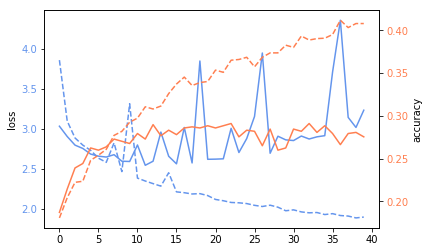

In [268]:
#plot training history

fig, ax1 = plt.subplots()


color = 'cornflowerblue' 
ax1.plot(history.history['loss'], label = 'training loss', linestyle = '--', color = color)
ax1.plot(history.history['val_loss'], label = 'valuation loss', color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('loss')

ax2 = ax1.twinx()

color = 'coral'
ax2.plot(history.history['accuracy'], label = 'training accuracy', linestyle = '--', color = color)
ax2.plot(history.history['val_accuracy'], label = 'valuation accuracy', color = color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('accuracy')

#fig.legend()

In [150]:
print(model.evaluate(X_val, Y_val))
print(model.evaluate(X_train, Y_train))

770/770 [==============================] - 0s 60us/step
[2.541330257948343, 0.26103895902633667]
2332/2332 [==============================] - 0s 50us/step
[2.4154292093541976, 0.28130361437797546]


## Generate city names

In [269]:
def output_to_char(vector):
    choice = np.random.choice(characters, p = vector)
    return choice

def start_matrix():
    vec = char_to_vec('<START>')
    matrix = np.expand_dims(vec, axis=0)
    return matrix
    
def predict_next(model, word):
    batch = pad_sequences(word, maxlen = maxlen - 1)
    prediction = model.predict(batch)
    predicted_char = output_to_char(prediction[0])
    return predicted_char
    
def generate_word(model):
    word = start_matrix()
    
    #keep generating new characters    
    finished = False
    
    while not finished:
        next_char = predict_next(model, [word])
        
        #signal stop when the last character was a stop symbol
        if next_char == '<STOP>':
            finished = True
        
        new_vec = np.expand_dims(char_to_vec(next_char), axis = 0)
        word = np.vstack([word, new_vec])
    
    #convert word to string
    indices = [np.nonzero(row)[0][0] for row in word]
    tokens = [characters[i] for i in indices]
    string = '' .join(tokens[1:-1])

    return string

In [270]:
for i in range(10):
    print(generate_word(model))

asbdk
eborna
eeoeeebue
yesasl
over
nsele
ule
eprsce
adlltrhvitnmn
lraglnhn
